In [3]:
# === Imports ===
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as sk_mape

# === Stałe / konfiguracja ===
CSV_PATH   = "final_processed_data.csv"
TARGET_COL = "EUR"
DIST_COL   = "TOTAL_KM"   # distance-only baseline

# Dokładnie te cechy z eksperymentu:
FEATURES = [
    "TOTAL_KM",
    "QTY_LOADS",
    "QTY_DELIVERIES",
    "COD_DP_MEAN_PRICE_PER_KM",
    "COD_LP_MEAN_PRICE_PER_KM",
    "START_DELIVERY_TIME_MEAN_PRICE_PER_KM",
    "ENTRY_WEEKDAY_MEAN_PRICE_PER_KM",
    "HU_KM_PERC",
    "TEMP_MIN",
    "TEMP_MAX",
]

# Dokładnie te hiperparametry z eksperymentu:
BEST_PARAMS = {
    "n_estimators": 581,
    "learning_rate": 0.14215770603493744,
    "max_depth": 4,
    "subsample": 0.9811039617263888,
    "min_samples_split": 10,
    "random_state": 42,  # tylko dla powtarzalności
}

N_SPLITS = 5  # jak w notatniku

# === 1) Wczytanie i podstawowe przygotowanie (kolejność wierszy = kolejność czasowa) ===
df = pd.read_csv(CSV_PATH, low_memory=False)

# rzut na numeric kluczowych kolumn (gdyby były stringi)
for col in set([TARGET_COL, DIST_COL] + FEATURES):
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# minimalne czyszczenie
df = df.dropna(subset=[TARGET_COL, DIST_COL])

# kontrola obecności kolumn
missing = [c for c in FEATURES if c not in df.columns]
if missing:
    raise ValueError(f"Brakuje kolumn w danych: {missing}")

# przygotowanie macierzy
X_full = df[FEATURES].values
y      = df[TARGET_COL].values
X_base = df[[DIST_COL]].values

# === 2) Definicje modeli ===
# Baseline: distance-only (imputacja + skalowanie + LR)
baseline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

# Full: imputacja + GBR z najlepszymi parametrami
prep = ColumnTransformer(
    transformers=[("num", SimpleImputer(strategy="median"), list(range(X_full.shape[1])))],
    remainder="drop"
)
full_model = Pipeline([
    ("prep", prep),
    ("gbr", GradientBoostingRegressor(**BEST_PARAMS))
])

# === 3) TimeSeriesSplit + MAPE ===
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

mape_base, mape_full = [], []

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X_full), start=1):
    # baseline
    baseline.fit(X_base[tr_idx], y[tr_idx])
    y_pred_b = baseline.predict(X_base[te_idx])
    mb = sk_mape(y[te_idx], y_pred_b)            # ułamek
    mape_base.append(mb)
    
    # full
    full_model.fit(X_full[tr_idx], y[tr_idx])
    y_pred_f = full_model.predict(X_full[te_idx])
    mf = sk_mape(y[te_idx], y_pred_f)            # ułamek
    mape_full.append(mf)
    
    print(f"Fold {fold}: Baseline MAPE = {mb*100:.3f}%, Full MAPE = {mf*100:.3f}%")

print("\n=== Ablation (TimeSeriesSplit) — MAPE ONLY ===")
print(f"Distance-only baseline:     {np.mean(mape_base)*100:.3f}% (±{np.std(mape_base)*100:.3f})")
print(f"Full model (best feats+params): {np.mean(mape_full)*100:.3f}% (±{np.std(mape_full)*100:.3f})")

print("\nFeatures used:", FEATURES)
print("Params used:", BEST_PARAMS)

Fold 1: Baseline MAPE = 17.777%, Full MAPE = 6.533%
Fold 2: Baseline MAPE = 17.873%, Full MAPE = 6.957%
Fold 3: Baseline MAPE = 18.500%, Full MAPE = 6.803%
Fold 4: Baseline MAPE = 17.248%, Full MAPE = 5.257%
Fold 5: Baseline MAPE = 14.944%, Full MAPE = 5.789%

=== Ablation (TimeSeriesSplit) — MAPE ONLY ===
Distance-only baseline:     17.268% (±1.229)
Full model (best feats+params): 6.268% (±0.645)

Features used: ['TOTAL_KM', 'QTY_LOADS', 'QTY_DELIVERIES', 'COD_DP_MEAN_PRICE_PER_KM', 'COD_LP_MEAN_PRICE_PER_KM', 'START_DELIVERY_TIME_MEAN_PRICE_PER_KM', 'ENTRY_WEEKDAY_MEAN_PRICE_PER_KM', 'HU_KM_PERC', 'TEMP_MIN', 'TEMP_MAX']
Params used: {'n_estimators': 581, 'learning_rate': 0.14215770603493744, 'max_depth': 4, 'subsample': 0.9811039617263888, 'min_samples_split': 10, 'random_state': 42}


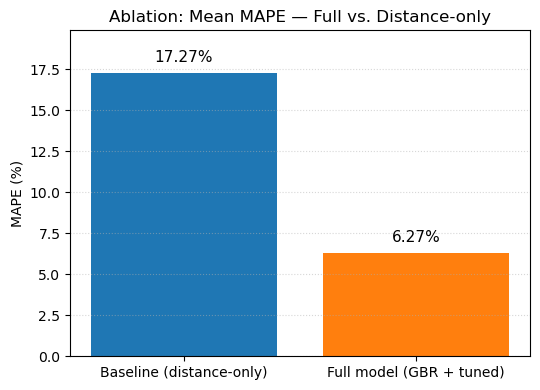

In [7]:
import numpy as np
import matplotlib.pyplot as plt

if 'mape_base' not in globals() or 'mape_full' not in globals():
    raise NameError("Run the previous cell first to create 'mape_base' and 'mape_full'.")

# mean MAPE in percent
mean_base = np.mean(np.array(mape_base, dtype=float)) * 100.0
mean_full = np.mean(np.array(mape_full, dtype=float)) * 100.0

labels = ["Baseline (distance-only)", "Full model (GBR + tuned)"]
values = [mean_base, mean_full]

plt.figure(figsize=(5.5, 4.0))
bars = plt.bar(labels, values, color=["tab:blue", "tab:orange"])

# annotate bars
for rect, val in zip(bars, values):
    plt.text(rect.get_x() + rect.get_width()/2,
             rect.get_height() + 0.5,  # 0.5 punktu powyżej słupka
             f"{val:.2f}%", ha="center", va="bottom", fontsize=11)

# increase ylim slightly to leave margin at the top
plt.ylim(0, max(values) * 1.15)

plt.ylabel("MAPE (%)")
plt.title("Ablation: Mean MAPE — Full vs. Distance-only")
plt.grid(axis="y", linestyle=":", alpha=0.5)
plt.tight_layout()
plt.show()

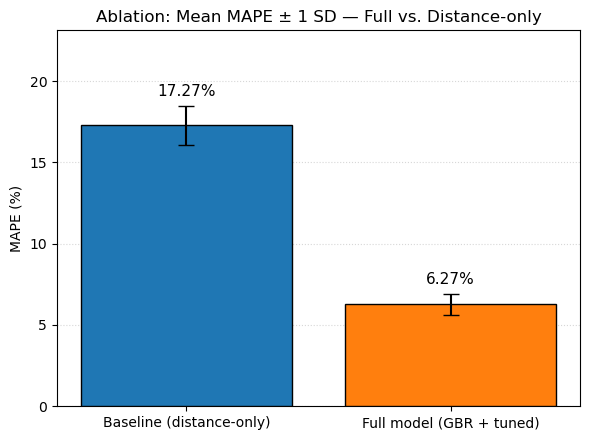

In [13]:
import numpy as np
import matplotlib.pyplot as plt

if 'mape_base' not in globals() or 'mape_full' not in globals():
    raise NameError("Run the previous cell first to create 'mape_base' and 'mape_full'.")

# percent values
base_pct = np.array(mape_base, dtype=float) * 100.0
full_pct = np.array(mape_full, dtype=float) * 100.0

means = np.array([base_pct.mean(), full_pct.mean()])
stds  = np.array([base_pct.std(),  full_pct.std()])

labels = ["Baseline (distance-only)", "Full model (GBR + tuned)"]
colors = ["tab:blue", "tab:orange"]

plt.figure(figsize=(6, 4.5))
bars = plt.bar(labels, means, yerr=stds, capsize=6,
               color=colors, edgecolor="black", zorder=3)

# annotate each bar just above its errorbar
for rect, mean, sd in zip(bars, means, stds):
    top_of_bar = mean + sd
    plt.text(rect.get_x() + rect.get_width()/2,
             top_of_bar + 0.4,
             f"{mean:.2f}%", ha="center", va="bottom", fontsize=11)

# add margin on top so labels don't hit the frame
plt.ylim(0, (means + stds).max() * 1.25)

plt.ylabel("MAPE (%)")
plt.title("Ablation: Mean MAPE ± 1 SD — Full vs. Distance-only")
plt.grid(axis="y", linestyle=":", alpha=0.5, zorder=0)
plt.tight_layout()
plt.show()